# Vector Auto Regression (VAR)


**The vector autoregressive (VAR) model is a workhouse multivariate time series model that relates current observations of a variable with past observations of itself and past observations of other variables in the system. ... Ability to capture the intertwined dynamics of time series data.**

###  What does a VAR model do?

**Vector autoregression (VAR) is a statistical model used to capture the relationship between multiple quantities as they change over time. ... VAR models generalize the single-variable (univariate) autoregressive model by allowing for multivariate time series. VAR models are often used in economics and the natural sciences.**

In [1]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")


# Read the Data

In [2]:
df = pd.read_csv("ice_cream_vs_heater.csv")
df

,Month,heater,ice cream
0,2004-01,27,13
1,2004-02,18,15
2,2004-03,14,16
3,2004-04,13,19
4,2004-05,13,21
...,...,...,...
193,2020-02,34,45
194,2020-03,25,44
195,2020-04,25,53
196,2020-05,27,70


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Month      198 non-null    object
 1   heater     198 non-null    int64 
 2   ice cream  198 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ KB


In [4]:
def parser(s):
    return datetime.strptime(s, "%Y-%m")

In [5]:
ice_n_heater_df = pd.read_csv("ice_cream_vs_heater.csv",parse_dates = [0], index_col = 0,squeeze = True,date_parser = parser)

In [6]:
ice_n_heater_df

,heater,ice cream
Month,,
2004-01-01,27,13
2004-02-01,18,15
2004-03-01,14,16
2004-04-01,13,19
2004-05-01,13,21
...,...,...
2020-02-01,34,45
2020-03-01,25,44
2020-04-01,25,53


In [7]:
#Infer the frequency

ice_n_heater_df = ice_n_heater_df.asfreq(pd.infer_freq(ice_n_heater_df.index))

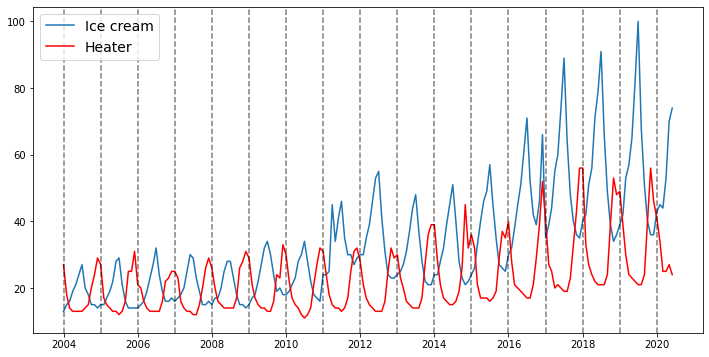

In [8]:
plt.figure(figsize = (12,6))
ice_cream = plt.plot(ice_n_heater_df["ice cream"])
heater, = plt.plot(ice_n_heater_df["heater"],color = "red")

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), color = "k", linestyle = "--", alpha = 0.5)
    
plt.legend(["Ice cream", "Heater"], fontsize = 14)

# Data Processing

In [9]:
## Normalize

avgs = ice_n_heater_df.mean() 
devs = ice_n_heater_df.std()

In [10]:
ice_n_heater_df.columns

Index(['heater', 'ice cream'], dtype='object')

In [11]:
avgs.loc["heater"], devs.loc["heater"]

(22.792929292929294, 9.795500391705835)

In [12]:
for col in ice_n_heater_df.columns:
    ice_n_heater_df[col] = (ice_n_heater_df[col] - avgs.loc[col])/ devs.loc[col]

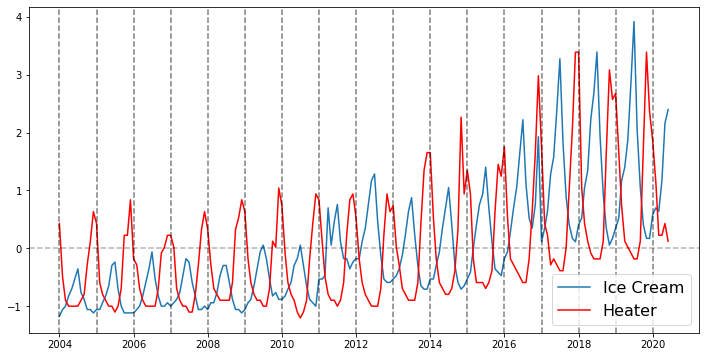

In [13]:
plt.figure(figsize = (12,6))

ice_cream = plt.plot(ice_n_heater_df["ice cream"])
heater, = plt.plot(ice_n_heater_df["heater"], color = "red")

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1),color = "k",linestyle = "--", alpha = 0.5)

plt.axhline(0,color = "k",linestyle = "--", alpha = 0.3)
plt.legend(["Ice Cream", "Heater"], fontsize = 16)

# Take the First Difference to remove the trend

In [14]:
ice_heater_df = ice_n_heater_df.diff().dropna()

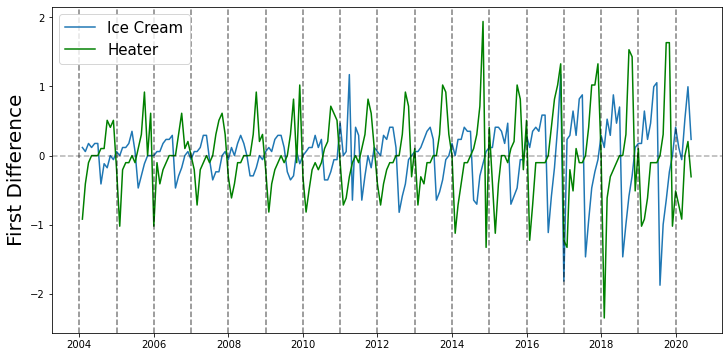

In [15]:
plt.figure(figsize = (12,6))
ice_cream = plt.plot(ice_heater_df["ice cream"])
heater, = plt.plot(ice_heater_df["heater"], color = "green")

for year in range(2004,2021):
    plt.axvline(datetime(year,1,1), color = "k", linestyle = "--", alpha = 0.5)
    
plt.axhline(0,color = "k", linestyle = "--",alpha = 0.3 )
plt.ylabel("First Difference", fontsize = 20)
plt.legend(["Ice Cream", "Heater"], fontsize = 15)

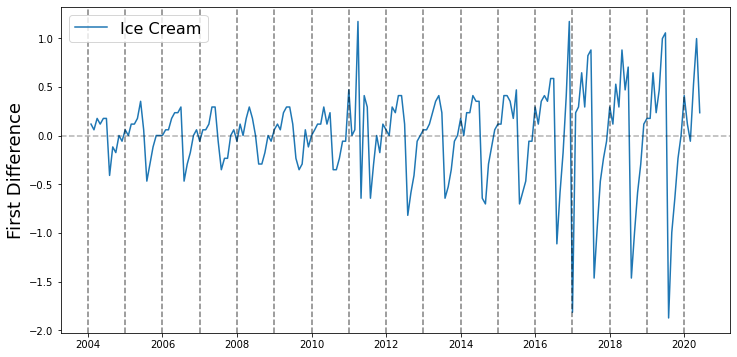

In [16]:
# plotting ice cream first difference

plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_heater_df['ice cream'])

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream'], fontsize=16)

# Remove Increasing Volatility

In [17]:
annual_volatility = ice_heater_df.groupby(ice_heater_df.index.year).std()

In [18]:
annual_volatility

,heater,ice cream
Month,,
2004,0.415481,0.184201
2005,0.474527,0.214837
2006,0.400148,0.227698
2007,0.359839,0.198947
2008,0.396182,0.183239
2009,0.499810,0.221038
2010,0.459566,0.211668
2011,0.443924,0.501018
2012,0.471104,0.389711


In [20]:
ice_heater_df["ice_cream_annual_vol"] = ice_heater_df.index.map(lambda d:annual_volatility.loc[d.year,"ice cream"])
ice_heater_df["heater_annual_vol"] = ice_heater_df.index.map(lambda d:annual_volatility.loc[d.year, "heater"]) 


In [21]:
ice_heater_df

,heater,ice cream,ice_cream_annual_vol,heater_annual_vol
Month,,,,
2004-02-01,-0.918789,0.117140,0.184201,0.415481
2004-03-01,-0.408351,0.058570,0.184201,0.415481
2004-04-01,-0.102088,0.175710,0.184201,0.415481
2004-05-01,0.000000,0.117140,0.184201,0.415481
2004-06-01,0.000000,0.175710,0.184201,0.415481
...,...,...,...,...
2020-02-01,-0.714614,0.117140,0.369810,0.426657
2020-03-01,-0.918789,-0.058570,0.369810,0.426657
2020-04-01,0.000000,0.527129,0.369810,0.426657


In [22]:
ice_heater_df["ice cream"] = ice_heater_df["ice cream"]/ice_heater_df["ice_cream_annual_vol"]
ice_heater_df["heater"] = ice_heater_df["heater"]/ice_heater_df["heater_annual_vol"]

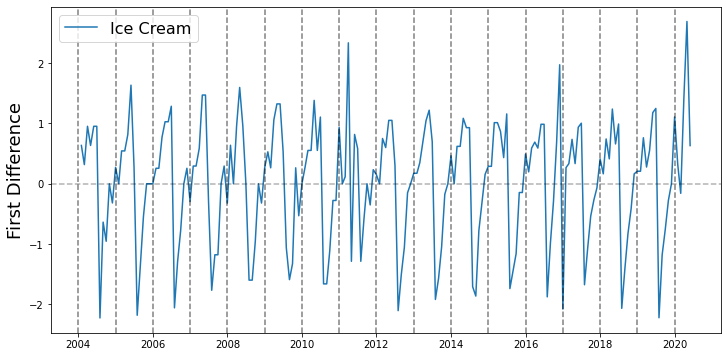

In [23]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_heater_df['ice cream'])

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream'], fontsize=16)

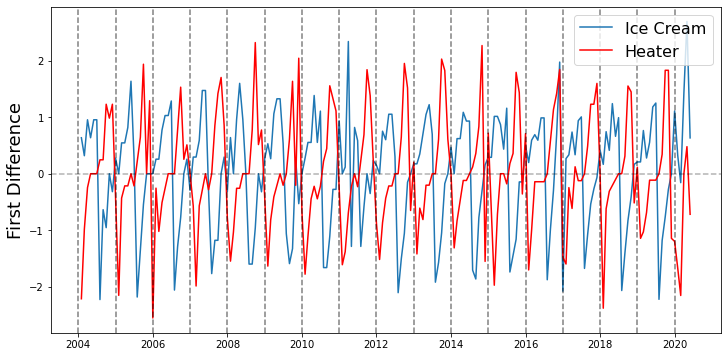

In [24]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_heater_df['ice cream'])
heater, = plt.plot(ice_heater_df['heater'], color='red')

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)

# Remove Seasonality

In [25]:
month_avgs = ice_heater_df.groupby(ice_heater_df.index.month).mean()

In [26]:
month_avgs

,heater,ice cream,ice_cream_annual_vol,heater_annual_vol
Month,,,,
1,-0.428360,0.130345,0.415976,0.580717
2,-1.483129,0.250194,0.402342,0.570997
3,-1.063595,0.433016,0.402342,0.570997
4,-0.442926,0.838085,0.402342,0.570997
5,-0.121663,0.967273,0.402342,0.570997
6,-0.128425,0.987311,0.402342,0.570997
7,-0.107093,0.735052,0.404376,0.580018
8,0.075720,-1.821285,0.404376,0.580018
9,0.544638,-1.307661,0.404376,0.580018


In [27]:
ice_heater_df["ice_cream_month_avg"] = ice_heater_df.index.map(lambda d: month_avgs.loc[d.month, "ice cream"])
ice_heater_df["heater_month_avg"] = ice_heater_df.index.map(lambda d: month_avgs.loc[d.month, "heater"])

In [28]:
ice_heater_df

,heater,ice cream,ice_cream_annual_vol,heater_annual_vol,ice_cream_month_avg,heater_month_avg
Month,,,,,,
2004-02-01,-2.211387,0.635934,0.184201,0.415481,0.250194,-1.483129
2004-03-01,-0.982838,0.317967,0.184201,0.415481,0.433016,-1.063595
2004-04-01,-0.245710,0.953901,0.184201,0.415481,0.838085,-0.442926
2004-05-01,0.000000,0.635934,0.184201,0.415481,0.967273,-0.121663
2004-06-01,0.000000,0.953901,0.184201,0.415481,0.987311,-0.128425
...,...,...,...,...,...,...
2020-02-01,-1.674916,0.316756,0.369810,0.426657,0.250194,-1.483129
2020-03-01,-2.153463,-0.158378,0.369810,0.426657,0.433016,-1.063595
2020-04-01,0.000000,1.425403,0.369810,0.426657,0.838085,-0.442926


In [29]:
ice_heater_df["ice cream"] = ice_heater_df["ice cream"] - ice_heater_df["ice_cream_month_avg"]
ice_heater_df["heater"] = ice_heater_df["heater"] - ice_heater_df["heater_month_avg"]

In [30]:
ice_heater_df

,heater,ice cream,ice_cream_annual_vol,heater_annual_vol,ice_cream_month_avg,heater_month_avg
Month,,,,,,
2004-02-01,-0.728257,0.385740,0.184201,0.415481,0.250194,-1.483129
2004-03-01,0.080757,-0.115049,0.184201,0.415481,0.433016,-1.063595
2004-04-01,0.197217,0.115816,0.184201,0.415481,0.838085,-0.442926
2004-05-01,0.121663,-0.331339,0.184201,0.415481,0.967273,-0.121663
2004-06-01,0.128425,-0.033411,0.184201,0.415481,0.987311,-0.128425
...,...,...,...,...,...,...
2020-02-01,-0.191787,0.066562,0.369810,0.426657,0.250194,-1.483129
2020-03-01,-1.089868,-0.591394,0.369810,0.426657,0.433016,-1.063595
2020-04-01,0.442926,0.587318,0.369810,0.426657,0.838085,-0.442926


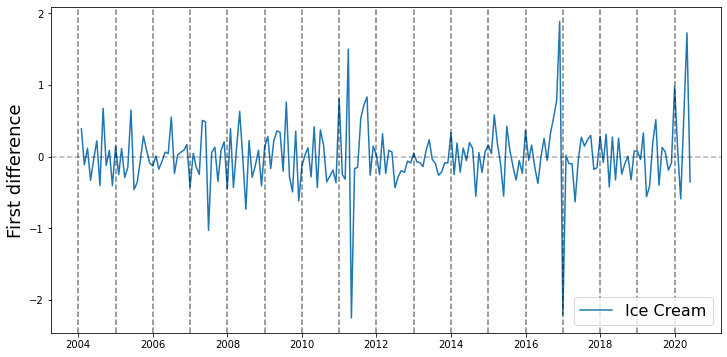

In [31]:
plt.figure(figsize = (12,6))
ice_cream, = plt.plot(ice_heater_df["ice cream"])

for year in range(2004,2021):
    plt.axvline(datetime(year,1,1), color = "k", linestyle = "--", alpha = 0.5 )

plt.axhline(0,color = "k", linestyle = "--", alpha = 0.3)

plt.ylabel("First difference", fontsize = 18)
plt.legend(["Ice Cream"], fontsize = 16)

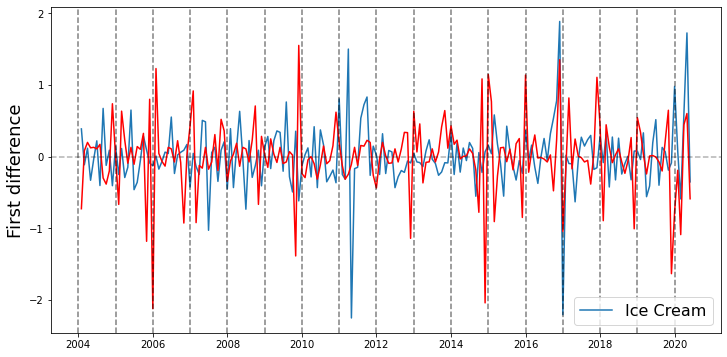

In [33]:
plt.figure(figsize = (12,6))
ice_cream, = plt.plot(ice_heater_df["ice cream"])
heater, = plt.plot(ice_heater_df["heater"], color = "red")

for year in range(2004,2021):
    plt.axvline(datetime(year,1,1), color = "k", linestyle = "--", alpha = 0.5 )

plt.axhline(0,color = "k", linestyle = "--", alpha = 0.3)

plt.ylabel("First difference", fontsize = 18)
plt.legend(["Ice Cream"], fontsize = 16)

# Heater PACF Plot

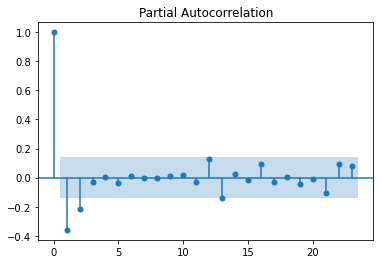

In [34]:
plot_pacf(ice_heater_df["heater"])
plt.show()

# Correlation between "Heater" & lagged "Ice Cream"

In [35]:
for lag in range(1,14):
    heater_series = ice_heater_df["heater"].iloc[lag:]
    lagged_ice_cream_series = ice_heater_df["ice cream"].iloc[:-lag]
    print("Lag : %s"%lag)
    print(pearsonr(heater_series,lagged_ice_cream_series))
    print("--------")

Lag : 1
(-0.03154450742591565, 0.6607284991749967)
--------
Lag : 2
(-0.09872703210944633, 0.1697084190508982)
--------
Lag : 3
(-0.0017838553789235791, 0.9803056762962026)
--------
Lag : 4
(0.06023971859825542, 0.4052979832528944)
--------
Lag : 5
(-0.05403486448015028, 0.45664426275062703)
--------
Lag : 6
(0.06461183026553835, 0.37453000434455314)
--------
Lag : 7
(-0.04949334618415863, 0.49768766857621993)
--------
Lag : 8
(0.07890837135977341, 0.2804548970433407)
--------
Lag : 9
(-0.05323501699600429, 0.4681034202228288)
--------
Lag : 10
(0.02953698906079118, 0.6882054906332707)
--------
Lag : 11
(-0.0597953635152257, 0.41752174204858805)
--------
Lag : 12
(-0.07513046035981792, 0.30944092525429134)
--------
Lag : 13
(0.19808902198429754, 0.007029107082073339)
--------


# Fit a VAR model

In [36]:
ice_heater_df = ice_heater_df[["ice cream", "heater"]]

In [37]:
model = VAR(ice_heater_df)

In [38]:
model_fit = model.fit(maxlags = 13)

In [39]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 02, Dec, 2021
Time:                     01:13:47
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.92349
Nobs:                     184.000    HQIC:                  -2.48459
Log likelihood:          -204.405    FPE:                  0.0571123
AIC:                     -2.86700    Det(Omega_mle):       0.0434311
--------------------------------------------------------------------
Results for equation ice cream
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.016054         0.034105           -0.471           0.638
L1.ice cream         -0.287811         0.079633           -3.614           0.000
L1.heater            -0.121251         0.073673         

# So our final model is:


##                                          $ \hat h_{t}  = -0.41h_{t-1} - 0.19h_{t-2} + 0.2i_{t-13} $